# Introduction
This notebook uses survey data collected from Dec 2022 to Mar 2023 on smartphone wellbeing feature awareness and usage. The CSV file used in this analysis has been deidentified and manipulated in Excel before being brough into Jupyter Notebooks.

# Data Setup

In [1]:
# import packages for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats


In [2]:
# import data
df = pd.read_csv('wellbeing_survey_responses.csv')
df.dropna(subset=['age'],inplace=True) #there is one row with all blanks including the age

## Data Encoding

In [3]:

# convert timestamp column from object to datetime data type
df['response_timestamp'] = pd.to_datetime(df['response_timestamp'])

# encode the ordinal age column to labels
age_ordinal_values = { 'Prefer not to answer': -1, '18 to 24 years': 1, '25 to 34 years': 2
                      , '35 to 44 years': 3, '45 to 54 years': 4, '55 to 64 years': 5,
                     '65+ years': 6}

df['age_encoded'] = df['age'].map(age_ordinal_values)

# encode the categorical feature learning column to one-hot encoding
flm_one_hot_df = pd.get_dummies(data=df['feature_learn_method'], prefix='flm', dummy_na=True)

df = pd.concat([df, flm_one_hot_df], axis=1)

# encode the categorical phone type column to iPhone flag, question was required in survey so data cannot be blank
def phone_type_mapping_func(ptype : str):
    if ptype == 'Prefer not to answer':
        return -1
    elif ptype == 'Apple iPhone':
        return 1
    else:
        return 0
    
df['iphone_flag'] = df['phone_type'].apply(phone_type_mapping_func)

In [4]:
# coalesce the awareness and usage columns to one column for analysis
# source: https://www.statology.org/pandas-coalesce/
df['all_phone_feature_aware'] = df[['iphone_aware', 'samsung_aware', 'pixel_aware', 'other_aware']].bfill(axis=1).iloc[:, 0]
df['all_phone_feature_usage'] = df[['iphone_usage', 'samsung_usage', 'pixel_usage', 'other_usage']].bfill(axis=1).iloc[:, 0]

## Calculate ACTA Score

In [5]:

# Calculate the autonomous regulation score by getting the average score for questions that are
# intrinsic and identified motivated
intrinsic_identified_columns_list = ['expected_interesting_intrinsic', 'belief_life_improvement_identified'
                                     ,'help_do_important_identified', 'expect_enjoyable_intrinsic'
                                     , 'be_of_value_life_identified', 'fun_to_use_intrinsic']


df['autonomous_regulation_score'] = df[intrinsic_identified_columns_list].mean(axis=1)

In [6]:
# Calculate the controlled regulation score by getting the average score for questions that are
# external and introjected motivated
external_introjected_columns_list = ['others_want_me_use_external', 'others_know_usage_introjected'
                                     ,'feel_bad_not_trying_introjected', 'required_usage_external'
                                     , 'pressure_usage_external', 'look_good_others_introjected']


df['controlled_regulation_score'] = df[external_introjected_columns_list].mean(axis=1)

In [7]:
# Calculate relative autonomy index (RAI) by subtracting the average for Controlled Regulation
# from the average for Autonomous Regulation
df['relative_autonomy_index'] = df['autonomous_regulation_score'] - df['controlled_regulation_score']

In [8]:
# Return the ACTA Score for people who used wellbeing features
df.loc[df['usage_flag'] == 1, ['autonomous_regulation_score', 'controlled_regulation_score', 'relative_autonomy_index' ]]

,autonomous_regulation_score,controlled_regulation_score,relative_autonomy_index
1,3.000000,1.000000,2.000000
3,2.666667,1.000000,1.666667
5,1.333333,1.000000,0.333333
7,1.333333,1.000000,0.333333
8,2.333333,1.000000,1.333333
...,...,...,...
349,4.166667,1.833333,2.333333
350,1.500000,1.166667,0.333333
351,3.333333,2.166667,1.166667
352,2.833333,2.333333,0.500000


In [9]:
df.columns

Index(['ID', 'response_timestamp', 'age', 'feature_learn_method',
       'autonomy_avgscore', 'relatedness_avgscore', 'competence_avgscore',
       'pressured_to_use_more', 'spend_more_time_than_should',
       'makes_me_do_unwanted_things', 'life_intrusive',
       'more_ability_insecurity', 'less_capable', 'lowered_confidence',
       'belonging_to_community', 'close_connect_important_persons',
       'close_to_some', 'phone_type', 'awareness_flag', 'awareness_count',
       'usage_flag', 'usage_count', 'others_want_me_use_external',
       'expected_interesting_intrinsic', 'belief_life_improvement_identified',
       'help_do_important_identified', 'others_know_usage_introjected',
       'feel_bad_not_trying_introjected', 'expect_enjoyable_intrinsic',
       'required_usage_external', 'be_of_value_life_identified',
       'fun_to_use_intrinsic', 'pressure_usage_external',
       'look_good_others_introjected', 'iphone_aware', 'iphone_usage',
       'pixel_aware', 'pixel_usage', 'oth

# Descriptive Statistics

In [10]:
# Helper function to print distribution count and percentages of total for columns
def print_column_value_counts(column):
    print(df[column].value_counts(), '\n')
    print(df[column].value_counts(normalize=True))

In [13]:
# Helper function to create a basic seaborn displot historgram for a column
def create_displot_from_column(column_x_value):
    displot = sns.displot(data=df, x=column_x_value)
    displot.set_xticklabels(rotation=45, ha='right')
    return displot

## Age Only

### How many surveyed participants in each age group?

In [46]:
print_column_value_counts(['age'])

age                 
25 to 34 years          117
18 to 24 years           74
35 to 44 years           49
65+ years                45
45 to 54 years           33
55 to 64 years           31
Prefer not to answer      4
dtype: int64 

age                 
25 to 34 years          0.331445
18 to 24 years          0.209632
35 to 44 years          0.138810
65+ years               0.127479
45 to 54 years          0.093484
55 to 64 years          0.087819
Prefer not to answer    0.011331
dtype: float64


In [15]:
age_order_list = ['18 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years'
, '55 to 64 years', '65+ years', 'Prefer not to answer']

df['age_categorical'] = pd.Categorical(df['age'], categories=age_order_list, ordered=True)

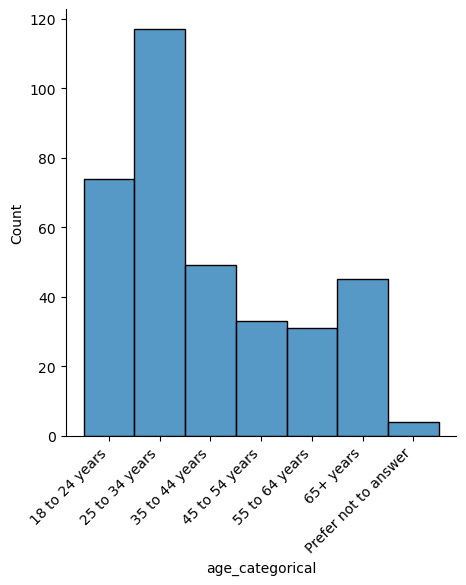

In [16]:
create_displot_from_column('age_categorical')
#age_displot = sns.displot(data=df, x='age_categorical')
#age_displot.set_xticklabels(rotation=45, ha='right')

## Feature Learn Method Only

### How do surveyed participants typically learn about smartphone features?

In [69]:
print_column_value_counts(['feature_learn_method'])

OrganicUsage         154
AnotherPerson        114
Proactive             43
SearchAfterUpdate     39
CompanyEmail           2
Name: feature_learn_method, dtype: int64 

OrganicUsage         0.437500
AnotherPerson        0.323864
Proactive            0.122159
SearchAfterUpdate    0.110795
CompanyEmail         0.005682
Name: feature_learn_method, dtype: float64


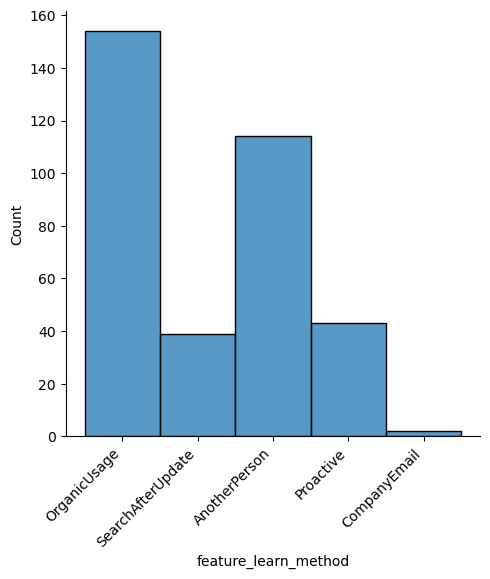

In [17]:
create_displot_from_column('feature_learn_method')

## Phone Type Only

### What types of smartphones were surveyed?

In [11]:
print_column_value_counts(['phone_type'])

phone_type          
Apple iPhone            247
Samsung                  62
Google Pixel             19
Motorola                  7
OnePlus                   7
Xiaomi                    4
Huawei                    2
Asus                      1
LG Nexus                  1
Prefer not to answer      1
Sony                      1
Xperia                    1
dtype: int64 

phone_type          
Apple iPhone            0.699717
Samsung                 0.175637
Google Pixel            0.053824
Motorola                0.019830
OnePlus                 0.019830
Xiaomi                  0.011331
Huawei                  0.005666
Asus                    0.002833
LG Nexus                0.002833
Prefer not to answer    0.002833
Sony                    0.002833
Xperia                  0.002833
dtype: float64


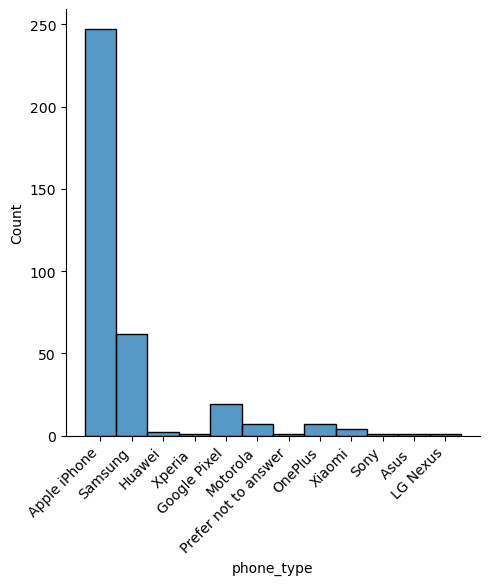

In [18]:
create_displot_from_column('phone_type')

## Awareness/Usage

### How many people were aware of smartphone wellbeing feature?

In [43]:
df['awareness_flag'].sum()

304

### What is the average, median, and mode for smarphone wellbeing feature awareness count?

In [21]:
awareness_total = df['awareness_flag'].sum()
awareness_percentage = awareness_total / df['awareness_flag'].count()
print('Total number of people aware of wellbeing features =', awareness_total)
print('Percentage of people aware of wellbeing features =', awareness_percentage)

Total number of people aware of wellbeing features =  304
Percentage of people aware of wellbeing features =  86.11898016997166


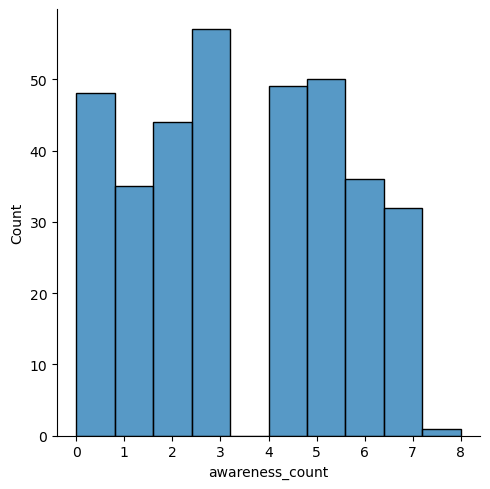

In [33]:
sns.displot(data=df, x='awareness_count')

In [32]:
print_column_value_counts(['awareness_count'])

awareness_count
3.0                57
5.0                50
4.0                49
0.0                48
2.0                44
6.0                36
1.0                35
7.0                32
8.0                 1
dtype: int64 

awareness_count
3.0                0.161932
5.0                0.142045
4.0                0.139205
0.0                0.136364
2.0                0.125000
6.0                0.102273
1.0                0.099432
7.0                0.090909
8.0                0.002841
dtype: float64


In [40]:
print('Awareness mean =', df['awareness_count'].mean())
print('Awareness median =', df['awareness_count'].median())
print('Awareness mode =', df['awareness_count'].mode()[0])

Awareness mean = 3.375
Awareness median = 3.0
Awareness mode = 3.0


See Google Form for images of how many of each feature was checked

### How many people use smartphone wellbeing features?

In [46]:
print('Number of people aware of at least one wellbeing feature =', df['usage_flag'].sum())


Number of people aware of at least one wellbeing feature = 251


### What is the average, median, and mode for smartphone wellbeing feature usage count?

In [47]:
usage_total = df['usage_flag'].sum()
usage_percentage = usage_total / df['usage_flag'].count()
print('Total number of people who use at least one wellbeing feature =', usage_total)
print('Percentage of people who use at least one wellbeing feature =', usage_percentage)

Total number of people who use at least one wellbeing feature = 251
Percentage of people who use at least one wellbeing feature = 0.7110481586402266


## Combinations

### Age vs Feature Learn Method

In [66]:
df.groupby('age_categorical')['feature_learn_method'].value_counts(normalize=True)

age_categorical       feature_learn_method
18 to 24 years        OrganicUsage            0.527027
                      AnotherPerson           0.283784
                      Proactive               0.094595
                      SearchAfterUpdate       0.081081
                      CompanyEmail            0.013514
25 to 34 years        OrganicUsage            0.470085
                      AnotherPerson           0.273504
                      SearchAfterUpdate       0.153846
                      Proactive               0.094017
                      CompanyEmail            0.008547
35 to 44 years        OrganicUsage            0.387755
                      AnotherPerson           0.285714
                      Proactive               0.183673
                      SearchAfterUpdate       0.142857
45 to 54 years        OrganicUsage            0.437500
                      AnotherPerson           0.312500
                      Proactive               0.125000
                      

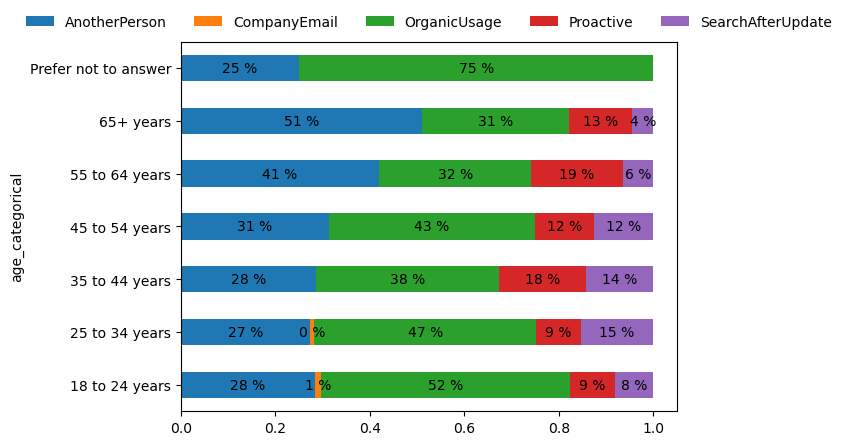

In [86]:
# Source: https://stackoverflow.com/questions/64754905/100-stacked-bar-chart-python-seaborn-matplotlib
df_grouped = df.groupby('age_categorical')['feature_learn_method'].value_counts(normalize=True).unstack('feature_learn_method')
df_grouped.plot.barh(stacked=True)

plt.legend(
    bbox_to_anchor=(0.5, 1.02),
    loc="lower center",
    borderaxespad=0,
    frameon=False,
    ncol=5,
)

for age_index, flm in df_grouped.reset_index(drop=True).iterrows():
    cumulative = 0
    for element in flm:
        if np.isnan(element):
            element = 0
        else:
            plt.text(
                cumulative + element / 2,
                age_index,
                f"{int(element * 100)} %",
                va="center",
                ha="center",
            )
        cumulative += element

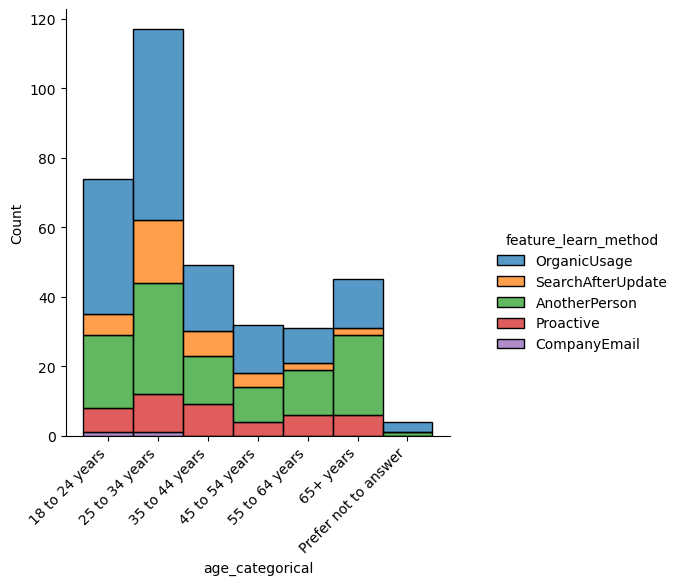

In [40]:
# stacked 100% bar chart
# chi-square test
# maybe combining the the FLM to passive vs active
chart = sns.displot(data=df, x='age_categorical', hue='feature_learn_method', multiple='stack')
chart.set_xticklabels(rotation=45, ha='right')
plt.show()

### Age vs Smartphone Type

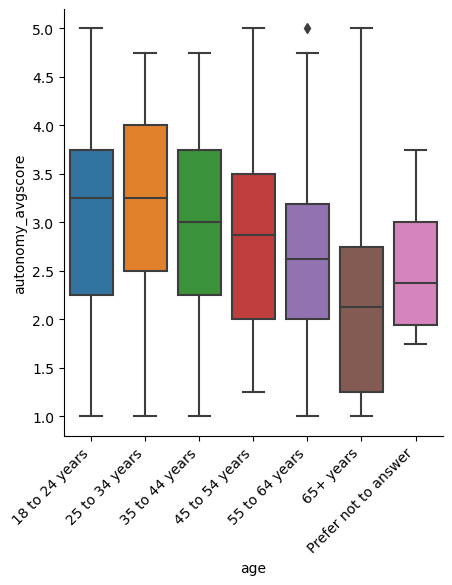

In [49]:
automony_age_boxplot = sns.catplot(data=df, x='age', y='autonomy_avgscore', kind='box', order=age_order_list)
automony_age_boxplot.set_xticklabels(rotation=45, ha='right')
plt.show()

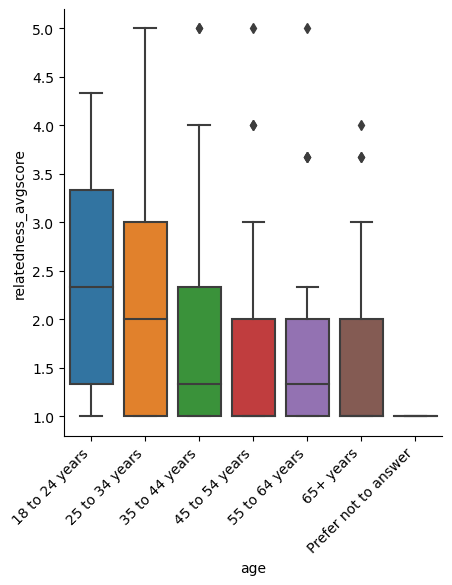

In [50]:
relatedness_age_boxplot = sns.catplot(data=df, x='age', y='relatedness_avgscore', kind='box', order=age_order_list)
relatedness_age_boxplot.set_xticklabels(rotation=45, ha='right')
plt.show()

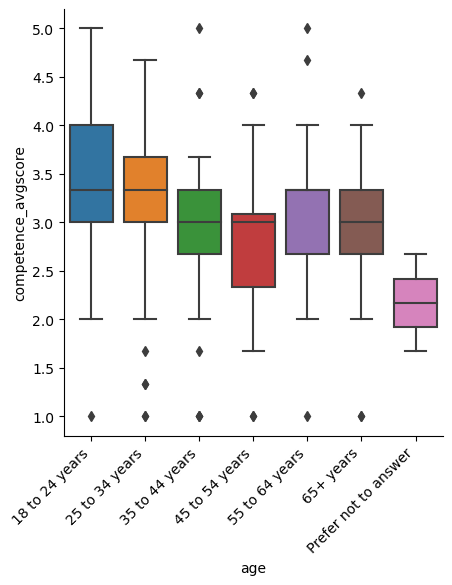

In [60]:
competence_age_boxplot = sns.catplot(data=df, x='age', y='competence_avgscore', kind='box', order=age_order_list)
competence_age_boxplot.set_xticklabels(rotation=45, ha='right')
plt.show()

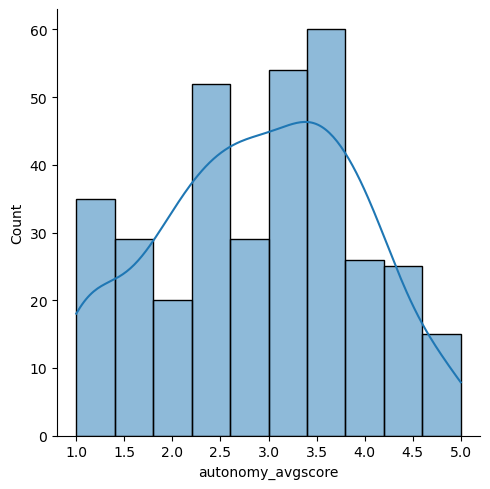

In [65]:
sns.displot(data=df, x='autonomy_avgscore', kde=True)

In [ ]:
sns.displot(data=df, x='autonomy_avgscore', kde=True)

# RQ1 What extent does smartphone usage impact perceive psychological wellbeing?

## What is the overall perceived psychological wellbeing of the surveyed population?

## What is the perceived psychological wellbeing by age?

## What is the perceived psychology wellbeing of iPhone versus Android users?

# RQ2 How aware of and widely used are smartphone features aimed to support wellbeing?

## Does age affect how one learns about smartphone features in general?
Hypothesis: Younger populations are more likely to be proactive about learning features on their smartphone in general

## Active learners of features are more likely to be aware of wellbeing features compared to passive leaners

## Is wellbeing feature awareness correlated with usage?

## Does the type of smartphone used affect awareness or usage of wellbeing features?

# RQ3